<a href="https://colab.research.google.com/github/DmitryKutsev/DeepHW/blob/master/Dmitry_Kutsev_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2020-10-23 19:16:14--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  28.4MB/s    in 23s     

2020-10-23 19:16:38 (28.1 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [2]:
!wget https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/Week%203/data.py

--2020-10-23 19:16:38--  https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/Week%203/data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10563 (10K) [text/plain]
Saving to: ‘data.py’

data.py             100%[===================>]  10.32K  --.-KB/s    in 0s      

2020-10-23 19:16:38 (93.4 MB/s) - ‘data.py’ saved [10563/10563]



In [3]:
!mv data.py mydata.py

In [4]:
import math
from tqdm import trange
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from tqdm import tqdm
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
import zipfile
from torch import nn
import seaborn as sns
from mydata import Downloader, Parser
import matplotlib.pyplot as plt

### **DATA**


In [5]:
data_path = './mydata/'

In [6]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
train = pd.read_csv('/content/drive/My Drive/dialogs_train.csv') 
valid = pd.read_csv('/content/drive/My Drive//dialogs_valid.csv') 

In [8]:
unique_categories = set(train.category.unique().tolist() + valid.category.unique().tolist())
category2index = {category: index for index, category in enumerate(unique_categories)}

In [9]:
train['target'] = train.category.map(category2index)
valid['target'] = valid.category.map(category2index)

In [10]:
valid['target'][:3]

0    7
1    3
2    7
Name: target, dtype: int64

In [11]:
class TextClassificationDataset(Dataset):
    
    def __init__(self, texts, targets, vocab, pad_index=0, max_length=32):
        super().__init__()
        
        self.texts = texts
        self.targets = targets
        self.vocab = vocab
        
        self.pad_index = pad_index
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def tokenization(self, text):
        
        tokens = wordpunct_tokenize(text)
        
        token_indices = [self.vocab[tok] for tok in tokens if tok in self.vocab]
        
        return token_indices
    
    def padding(self, tokenized_text):
        
        tokenized_text = tokenized_text[:self.max_length]
        
        tokenized_text += [self.pad_index] * (self.max_length - len(tokenized_text))
        
        return tokenized_text
    
    def __getitem__(self, index):
        
        text = self.texts[index]        
        target = self.targets[index]
        
        tokenized_text = self.tokenization(text)
        tokenized_text = self.padding(tokenized_text)
        
        tokenized_text = torch.tensor(tokenized_text)
        
        return tokenized_text, target

In [12]:
train_x = list(train.question)
train_y = list(train.target)

valid_x = list(valid.question)
valid_y = list(valid.target)

### **Embeddings**

In [13]:
def load_embeddings(zip_path, filename, pad_token='PAD', max_words=100_000, verbose=True):
    
    vocab = dict()
    embeddings = list()

    with zipfile.ZipFile(zip_path) as zipped_file:
        with zipped_file.open(filename) as file_object:

            vocab_size, embedding_dim = file_object.readline().decode('utf-8').strip().split()

            vocab_size = int(vocab_size)
            embedding_dim = int(embedding_dim)
            
            max_words = vocab_size if max_words <= 0 else max_words
            
            vocab[pad_token] = len(vocab)
            embeddings.append(np.zeros(embedding_dim))

            progress_bar = tqdm(total=max_words, disable=not verbose)

            for line in file_object:
                parts = line.decode('utf-8').strip().split()

                token = ' '.join(parts[:-embedding_dim]).lower()
                
                if token in vocab:
                    continue
                
                word_vector = np.array(list(map(float, parts[-embedding_dim:])))

                vocab[token] = len(vocab)
                embeddings.append(word_vector)

                progress_bar.update()
                
                if len(vocab) == max_words:
                    break

            progress_bar.close()

    embeddings = np.stack(embeddings)
    
    return vocab, embeddings

In [14]:
vocab, embeddings = load_embeddings('./wiki-news-300d-1M.vec.zip', 'wiki-news-300d-1M.vec', max_words=100_000)

100%|█████████▉| 99999/100000 [00:18<00:00, 5433.44it/s]


In [15]:
index2token = {index: token for token, index in vocab.items()}

In [16]:
emb_norms = np.linalg.norm(embeddings, axis=1)

In [17]:
train_dataset = TextClassificationDataset(texts=train_x, targets=train_y, vocab=vocab)
x, y = train_dataset[0]

In [18]:
embeddings = torch.tensor(embeddings).float()
embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)
x_embed = embedding_layer(x)

In [19]:
train_dataset = TextClassificationDataset(texts=train_x, targets=train_y, vocab=vocab)
valid_dataset = TextClassificationDataset(texts=valid_x, targets=valid_y, vocab=vocab)

train_loader = DataLoader(train_dataset, batch_size=128)
valid_loader = DataLoader(valid_dataset, batch_size=128)

### **AVERAGE MODEL**

In [ ]:
class DeepAverageNetwork(nn.Module):
    
    def __init__(self, embeddings, linear_1_size, linear_2_size, n_classes):
        super().__init__()
        
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)
        
        self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
        
        self.linear_1 = nn.Linear(in_features=embeddings.shape[-1], out_features=linear_1_size)
        self.linear_2 = nn.Linear(in_features=linear_1_size, out_features=linear_2_size)
        self.linear_3 = nn.Linear(in_features=linear_2_size, out_features=n_classes)
        
    def forward(self, x):
        

        x = self.embedding_layer(x)
        x = x.sum(dim=1)
        x = self.batch_norm(x)
        x = self.linear_1(x)
        x = torch.relu(x)
        x = self.linear_2(x)
        x = torch.relu(x)
        
        x = self.linear_3(x)
        
        x = torch.softmax(x, dim=-1)
        return x

In [ ]:

model = DeepAverageNetwork(embeddings=embeddings,
                           linear_1_size=256, 
                           linear_2_size=128, 
                           n_classes=len(category2index))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

In [ ]:

epochs = 6
train_losses = []
test_losses = []
train_acc = 0
acc_list = []
train_iter_losses = []

for epoch in trange(epochs):
  counter = 0
  for x, y in train_loader:

    y_pred = model.forward(x)
    train_loss = criterion(y_pred, y)
    train_acc += (y_pred.argmax(1) == y).sum().item()
    train_iter_losses.append(train_loss)
    
    

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
  
  train_losses.append(train_loss)
  scheduler.step()

  for x, y in valid_loader:        
      with torch.no_grad():
          
          x_forw = model.forward(x)
          y_pred = torch.softmax(x_forw, dim=-1)
          optimizer.zero_grad()
          test_loss = criterion(y_pred, y)
          test_acc = (y_pred.argmax(1) == y).sum().item()
          acc_list.append(test_acc)
          optimizer.step()
          optimizer.zero_grad()
          optimizer.step()

  test_losses.append(test_loss)

  print(f"epoch {epoch} test loss {test_loss}, train loss {train_loss}")

 17%|█▋        | 1/6 [00:24<02:01, 24.30s/it]

epoch 0 test loss 1.9873653650283813, train loss 1.415579915046692


 33%|███▎      | 2/6 [00:49<01:38, 24.55s/it]

epoch 1 test loss 1.985883116722107, train loss 1.4118012189865112


 50%|█████     | 3/6 [01:14<01:13, 24.56s/it]

epoch 2 test loss 1.987344741821289, train loss 1.411537766456604


 67%|██████▋   | 4/6 [01:38<00:48, 24.44s/it]

epoch 3 test loss 1.98789381980896, train loss 1.4108545780181885


 83%|████████▎ | 5/6 [02:02<00:24, 24.47s/it]

epoch 4 test loss 1.9880822896957397, train loss 1.4094654321670532


100%|██████████| 6/6 [02:27<00:00, 24.54s/it]

epoch 5 test loss 1.9881165027618408, train loss 1.4084891080856323


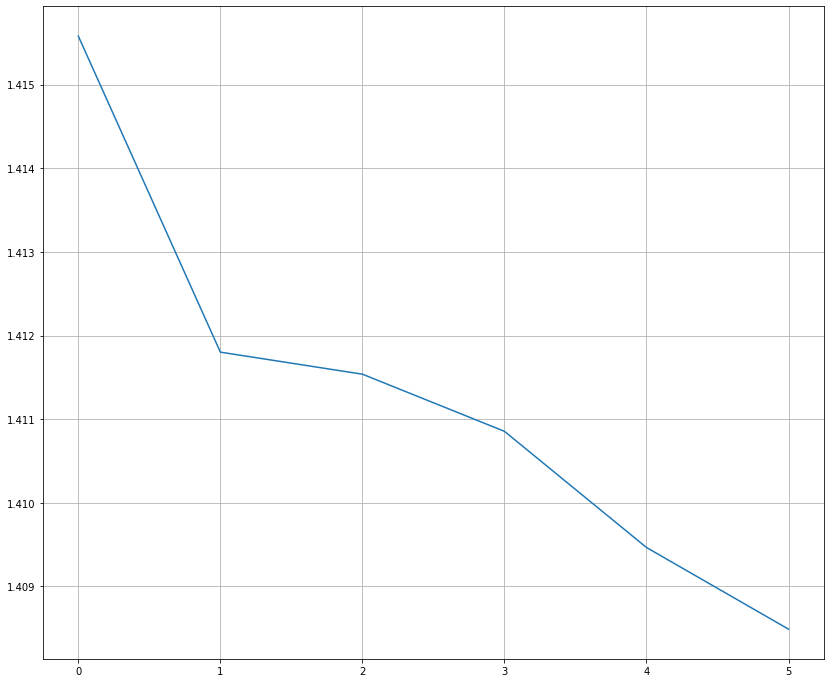

In [ ]:
plt.figure(figsize=(14, 12))
plt.plot(range(epochs), train_losses)
plt.grid()

### **CNN**

In [ ]:
class MyCNN(nn.Module):

  def __init__(self, embeddings, c1_in, c2_in, c2_out, l1_out, l2_out, n_classes):

    super().__init__()

    self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)

    self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
    self.conv1 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding=1)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=2, stride=1, padding=1)

    self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
    self.dropout = nn.Dropout(p=0.5)
    
    self.linear_1 = nn.Linear(in_features=101, out_features=32)
    self.linear_2 = nn.Linear(in_features=32, out_features=16)
    self.linear_3 = nn.Linear(in_features=16, out_features=n_classes)


  def forward(self, x):
    residual = x
    x = self.embedding_layer(x)
    x = self.conv1(x)
    x = torch.max_pool1d(x, kernel_size=3)
    x = self.relu(x)
    x = self.conv2(x)
    x = x.sum(dim=1)
    x = self.linear_1(x)
    x = torch.relu(x)
    x += residual
    x = self.linear_2(x)
    x = self.dropout(x)
    x = torch.relu(x)
    x = self.linear_3(x)
    x = torch.softmax(x, dim=-1)
 

    return x


In [ ]:
model = MyCNN(embeddings=embeddings,
                          c1_in=32, 
                          c2_in=64, 
                          c2_out=101,
                          l1_out=32, 
                          l2_out=16,
                           n_classes=len(category2index))


In [ ]:
CUDA = torch.cuda.is_available()
if CUDA:
  model = model.CUDA()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)


In [ ]:
epochs = 6
train_losses = []
train_iter_losses = []
test_losses = []
train_acc = 0
acc_list = []

for i in trange(epochs):
  for x, y in train_loader:
    if CUDA:
      x = x.CUDA()
      y = y.CUDA()

  for x, y in train_loader:

    y_pred = model.forward(x)
    train_loss = criterion(y_pred, y)
    train_acc += (y_pred.argmax(1) == y).sum().item()
    train_iter_losses.append(train_loss)
    

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

  
  train_losses.append(train_loss)
  scheduler.step()

  for x, y in valid_loader:        
      with torch.no_grad():
          
          x_forw = model.forward(x)
          y_pred = torch.softmax(x_forw, dim=-1)
          optimizer.zero_grad()
          test_loss = criterion(y_pred, y)
          test_acc = (y_pred.argmax(1) == y).sum().item()
          acc_list.append(test_acc)
          optimizer.step()
          optimizer.zero_grad()
          optimizer.step()

  test_losses.append(test_loss)

  print(f"epoch { i } test loss {test_loss}, train loss {train_loss}")


 17%|█▋        | 1/6 [03:18<16:30, 198.06s/it]

epoch 0 test loss 2.0793299674987793, train loss 2.085638999938965



 33%|███▎      | 2/6 [06:30<13:05, 196.26s/it]

epoch 1 test loss 2.0627036094665527, train loss 2.0240092277526855



 50%|█████     | 3/6 [09:35<09:38, 192.94s/it]

epoch 2 test loss 2.068904399871826, train loss 2.1490092277526855



 67%|██████▋   | 4/6 [12:33<06:17, 188.61s/it]

epoch 3 test loss 2.066404104232788, train loss 2.0240092277526855



 83%|████████▎ | 5/6 [15:25<03:03, 183.51s/it]

epoch 4 test loss 2.0628466606140137, train loss 2.0240092277526855



100%|██████████| 6/6 [18:11<00:00, 181.95s/it]

epoch 5 test loss 2.0628907680511475, train loss 1.9615092277526855


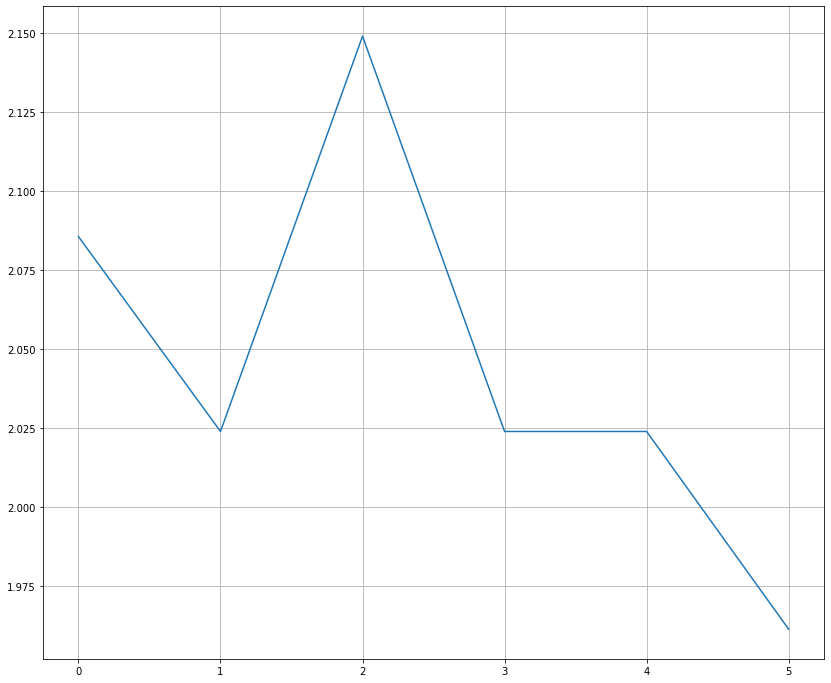

In [ ]:
plt.figure(figsize=(14, 12))
plt.plot(range(epochs), train_losses)
plt.grid()

### **PARALLEL CNN**

In [32]:
class MyParallelCNN(nn.Module):

  def __init__(self, embeddings, c1_in, c2_in, c2_out, l1_out, l2_out, n_classes):

    super().__init__()

    self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)

    self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
    self.conv1 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding=1)

    self.relu = nn.ReLU()
    self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=2, stride=1, padding=1)

    self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
    self.dropout = nn.Dropout(p=0.5)
    
    self.linear_1 = nn.Linear(in_features=101, out_features=32)
    self.linear_2 = nn.Linear(in_features=32, out_features=16)
    self.linear_3 = nn.Linear(in_features=16, out_features=n_classes)


  def forward(self, x):

    x = self.embedding_layer(x)
    x1 = self.conv1(x)
    x1 = torch.max_pool1d(x1,padding=1, kernel_size=3)

    x2 = self.conv2(x)
    x2 = torch.avg_pool1d(x2, padding=1, kernel_size=3)
    x = torch.cat([x1, x2], dim=1)
    x = self.relu(x)
    x = self.linear_1(x)
    x = x.sum(dim=1)
    x = torch.relu(x)
    x = self.linear_2(x)
    x = self.dropout(x)
    x = torch.relu(x)
    x = self.linear_3(x)
 

    return x
 



In [33]:
model = MyParallelCNN(embeddings=embeddings,
                          c1_in=32, 
                          c2_in=64, 
                          c2_out=101,
                          l1_out=32, 
                          l2_out=16,
                           n_classes=len(category2index))

In [34]:
CUDA = torch.cuda.is_available()
if CUDA:
  model = model.CUDA()

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

In [ ]:
epochs = 6
train_losses = []
test_losses = []
train_acc = 0
acc_list = []

for i in trange(epochs):
  for x, y in train_loader:
    if CUDA:
      x = x.CUDA()
      y = y.CUDA()

  for x, y in train_loader:

    y_pred = model.forward(x)
    train_loss = criterion(y_pred, y)
    train_acc += (y_pred.argmax(1) == y).sum().item()
    

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
  
  train_losses.append(train_loss)
  scheduler.step()

  for x, y in valid_loader:        
      with torch.no_grad():
          
          x_forw = model.forward(x)
          y_pred = torch.softmax(x_forw, dim=-1)
          optimizer.zero_grad()
          test_loss = criterion(y_pred, y)
          test_acc = (y_pred.argmax(1) == y).sum().item()
          acc_list.append(test_acc)
          optimizer.step()
          optimizer.zero_grad()
          optimizer.step()

  test_losses.append(test_loss)

  print(f"epoch {i} test loss {test_loss}, train loss {train_loss}")


  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
epochs = 6
train_losses = []
test_losses = []
train_acc = 0
acc_list = []

for i in trange(epochs):
  for x, y in train_loader:
    if CUDA:
      x = x.CUDA()
      y = y.CUDA()

  for x, y in train_loader:

    y_pred = model.forward(x)
    train_loss = criterion(y_pred, y)
    train_acc += (y_pred.argmax(1) == y).sum().item()
    

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
  
  train_losses.append(train_loss)
  scheduler.step()

  for x, y in valid_loader:        
      with torch.no_grad():
          
          x_forw = model.forward(x)
          y_pred = torch.softmax(x_forw, dim=-1)
          optimizer.zero_grad()
          test_loss = criterion(y_pred, y)
          test_acc = (y_pred.argmax(1) == y).sum().item()
          acc_list.append(test_acc)
          optimizer.step()
          optimizer.zero_grad()
          optimizer.step()

  test_losses.append(test_loss)

  print(f"epoch {epoch} test loss {test_loss}, train loss {train_loss}")



  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [03:24<17:00, 204.13s/it]

epoch 5 test loss 2.06768536567688, train loss 2.022841453552246




 33%|███▎      | 2/6 [06:48<13:36, 204.19s/it]

epoch 5 test loss 2.0626349449157715, train loss 2.0073325634002686




 50%|█████     | 3/6 [10:11<10:11, 203.97s/it]

epoch 5 test loss 2.0507915019989014, train loss 2.0209686756134033




 67%|██████▋   | 4/6 [13:33<06:46, 203.38s/it]

epoch 5 test loss 2.0471911430358887, train loss 1.9537488222122192




 83%|████████▎ | 5/6 [16:56<03:23, 203.22s/it]

epoch 5 test loss 2.0413196086883545, train loss 1.9647749662399292




100%|██████████| 6/6 [20:19<00:00, 203.22s/it]

epoch 5 test loss 2.0301313400268555, train loss 1.950714349746704


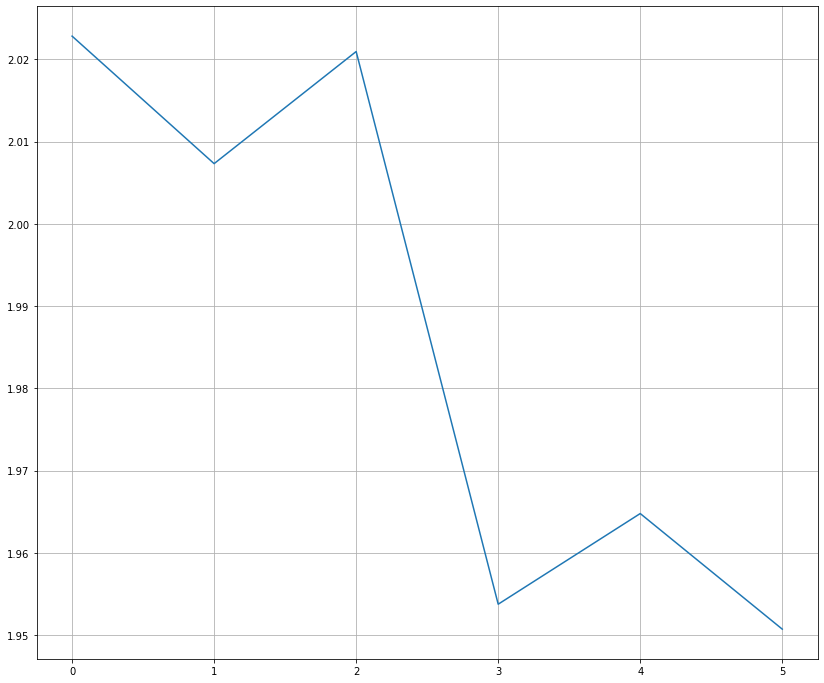

In [ ]:
plt.figure(figsize=(14, 12))
plt.plot(range(epochs), train_losses)
plt.grid()

### **LSTM**

In [ ]:
class LSTM(nn.Module):
    
    def __init__(self, embeddings, hidden_size, linear_1_size, linear_2_size, n_classes):
        super().__init__()
        
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)
        
        self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])

        self.lstm = nn.LSTM(input_size=300, hidden_size=128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)

        
        self.linear_1 = nn.Linear(in_features=256, out_features=32)

        self.linear_2 = nn.Linear(in_features=32, out_features=16)
        self.linear_3 = nn.Linear(in_features=16, out_features=128)
        
    def forward(self, x):

        x = self.embedding_layer(x)
        x, _ = self.lstm(x)
        x = x.mean(dim=1)
        x = self.linear_1(x)
        x = torch.relu(x)
        x = self.linear_2(x)
        x = torch.relu(x)
        
        x = self.linear_3(x)
        
        
        return x

In [ ]:
model = LSTM(embeddings=embeddings,
                           linear_1_size=256, 
                           linear_2_size=128,
                            hidden_size = 64,
                           n_classes=len(category2index))

In [ ]:
CUDA = torch.cuda.is_available()
if CUDA:
  model = model.CUDA()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

In [ ]:
epochs = 6
train_losses = []
test_losses = []
train_acc = 0
acc_list = []

for i in trange(epochs):
  for x, y in train_loader:
    if CUDA:
      x = x.CUDA()
      y = y.CUDA()

  for x, y in train_loader:

    y_pred = model.forward(x)
    train_loss = criterion(y_pred, y)
    train_acc += (y_pred.argmax(1) == y).sum().item()
    

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
  
  train_losses.append(train_loss)
  scheduler.step()

  for x, y in valid_loader:        
      with torch.no_grad():
          
          x_forw = model.forward(x)
          y_pred = torch.softmax(x_forw, dim=-1)
          optimizer.zero_grad()
          test_loss = criterion(y_pred, y)
          test_acc = (y_pred.argmax(1) == y).sum().item()
          acc_list.append(test_acc)
          optimizer.step()
          optimizer.zero_grad()
          optimizer.step()

  test_losses.append(test_loss)

  print(f"epoch {epoch} test loss {test_loss}, train loss {train_loss}")



  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [16:07<1:20:36, 967.35s/it]

epoch 5 test loss 4.6941447257995605, train loss 2.1845030784606934




 33%|███▎      | 2/6 [32:13<1:04:28, 967.11s/it]

epoch 5 test loss 4.6647443771362305, train loss 1.7579470872879028




 50%|█████     | 3/6 [48:19<48:20, 966.77s/it]  

epoch 5 test loss 4.530211925506592, train loss 1.3703759908676147




 67%|██████▋   | 4/6 [1:04:27<32:13, 966.99s/it]

epoch 5 test loss 4.467827796936035, train loss 1.2999860048294067




 83%|████████▎ | 5/6 [1:20:34<16:07, 967.03s/it]

epoch 5 test loss 4.4262471199035645, train loss 0.9905573129653931




100%|██████████| 6/6 [1:36:41<00:00, 966.94s/it]

epoch 5 test loss 4.390498161315918, train loss 0.9315201640129089


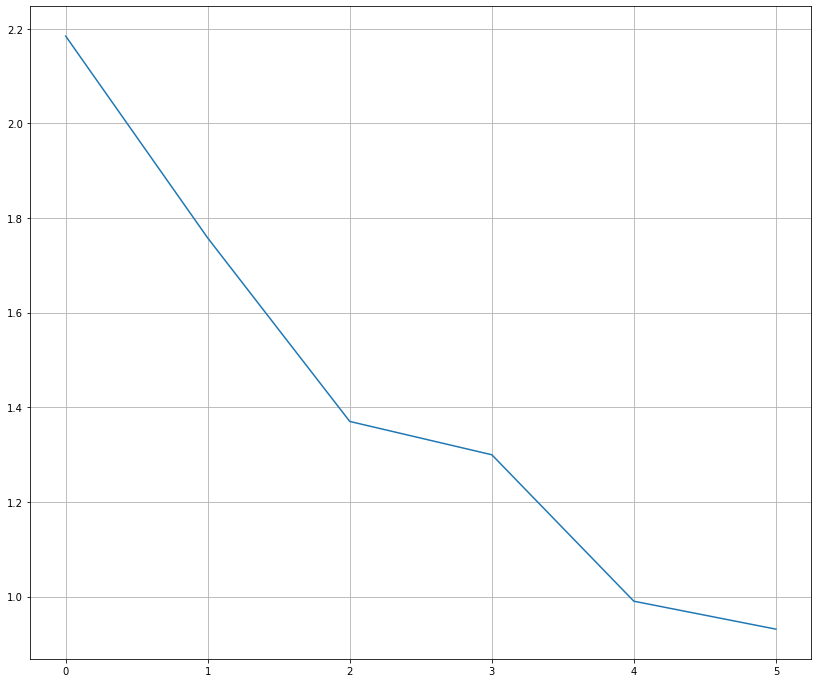

In [ ]:
plt.figure(figsize=(14, 12))
plt.plot(range(epochs), train_losses)
plt.grid()